## Analysis and Prediction Model of Fuel Consumption and Carbon Dioxide Emissions of Light-Duty Vehicles

In this notebook we will reproduce the results obtained via the methodology described in the paper "Analysis and Prediction Model of Fuel Consumption and Carbon Dioxide Emissions of Light-Duty Vehicles" by Hien NLH, Kor A-L. 

### Summary of Techniques used

Data from the Open Government of Canada is collected on light duty vehicles, cleaned and combined into one spreadsheet (vehicles between 2017-2021). Descriptive statistics (mean, median, mode) and dispersion statistics (std, variance, range) are computed. Inferential statistics: t-test, ANOVA, correlation, Chi-Square. 

### Machine learning techniques used

#### Single variable
1. Time series regression, persistence models (walk forward validation), autoregression models (stats models), optimized autoregression (walk-forward over time steps). 
2. Linear Regression: using the sklearn model and the dataset is split into training and testing sets with 80%:20% ratio;
3. Univariate Polynomial Regression: using the sklearn model and 5 different degrees (from Degree 1 to Degree 5).

#### Multiple variables
1. Multiple Linear Regression: using the sklearn model and the dataset is split into training and testing sets with 80%:20% ratio;
2. Logarithmic Regression: using the sklearn model with log transformed predictor values and exponential transformed predictor values;
3. Exponential Regression: the dataset is split into training and testing sets with 75%:25% ratio;
4. Transformation of data: the dataset is split into training and testing sets with 75%:25% ratio;
5. Multivariate Polynomial Regression: using the sklearn model and 5 different degrees (from Degree 1 to Degree 5).
    
 
#### Deep learning
Convolutional Neural Network (CNN) is used in this study to predict a variable from multiple variables. Since CNN is normally used for image classification, to use CNN for regression problems, this research uses a one-dimensional convolutional network by reshaping input data.

#### Target variable

Total fuel consumption and CO2 emissions.

#### Function

ML as a function of data of engine size, number of cylinders, fuel consumption in a city and on a highway. Moreover, total fuel consumption and CO2 emission data were used to predict each other.

#### Evaluation of predictive accuracy: 

Efficiency and error statistics analysis using Nash-Sutcliffe efficiency coefficient. Bias, Mean Absolute Error (MAE), Root Mean Squared Error (RMSE). 

### Reference

Hien NLH, Kor A-L. Analysis and Prediction Model of Fuel Consumption and Carbon Dioxide Emissions of Light-Duty Vehicles. Applied Sciences. 2022; 12(2):803. https://doi.org/10.3390/app12020803 


In [38]:
import sys, os
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
sys.path.append(os.path.abspath(os.path.join('..','./data/', './clean-data/')))
paths = sys.path
clean_path = [item for item in paths if "machine-learning-capstone\\data\\clean-data" in item]
clean_data = clean_path[0]

file_name_2022_1995 = "1995_2022_vehicle_fuel_consumption.csv"

master_df = pd.read_csv(Path(clean_data,f'{file_name_2022_1995}'))
master_df['number_of_gears'].fillna(0, inplace=True)
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26159 entries, 0 to 26158
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   model_year                     26159 non-null  int64  
 1   make_                          26159 non-null  object 
 2   model.1_                       26159 non-null  object 
 3   vehicleclass_                  26159 non-null  object 
 4   enginesize_(l)                 26159 non-null  float64
 5   cylinders_                     26159 non-null  float64
 6   transmission_                  26159 non-null  object 
 7   fuel_type                      26159 non-null  object 
 8   fuelconsumption_city(l/100km)  26159 non-null  float64
 9   fuelconsumption_hwy(l/100km)   26159 non-null  float64
 10  fuelconsumption_comb(l/100km)  26159 non-null  float64
 11  fuelconsumption_comb(mpg)      26159 non-null  int64  
 12  co2emissions_(g/km)            26159 non-null 

In [11]:
# Subset data for vehicles between 2017 and 2021

subset_of_data = master_df[(master_df["model_year"]>=2017) & (master_df['model_year']<=2021)]

subset_of_data.head()

,model_year,make_,model.1_,vehicleclass_,enginesize_(l),cylinders_,transmission_,fuel_type,fuelconsumption_city(l/100km),fuelconsumption_hwy(l/100km),fuelconsumption_comb(l/100km),fuelconsumption_comb(mpg),co2emissions_(g/km),co2_rating,smog_rating,transmission_type,number_of_gears,mapped_fuel_type,type_of_wheel_drive
955,2021,acura,ilx,compact,2.4,4.0,AM8,Z,9.9,7.0,8.6,33,199,6.0,3.0,automated manual,8.0,premium gasoline,unspecified
956,2021,acura,nsx,two-seater,3.5,6.0,AM9,Z,11.1,10.8,11.0,26,256,4.0,3.0,automated manual,9.0,premium gasoline,unspecified
957,2021,acura,rdx sh-awd,suv - small,2.0,4.0,AS10,Z,11.0,8.6,9.9,29,232,5.0,6.0,automatic with select Shift,10.0,premium gasoline,All-wheel drive
958,2021,acura,rdx sh-awd a-spec,suv - small,2.0,4.0,AS10,Z,11.3,9.1,10.3,27,242,5.0,6.0,automatic with select Shift,10.0,premium gasoline,All-wheel drive
959,2021,acura,tlx sh-awd,compact,2.0,4.0,AS10,Z,11.2,8.0,9.8,29,230,5.0,7.0,automatic with select Shift,10.0,premium gasoline,All-wheel drive


In [19]:
# compute "Total fuel consumption (l/100 km) as the average of fuelconsumption_city(l/100km)	fuelconsumption_hwy(l/100km)	
subset_copy = subset_of_data.copy()
subset_copy['fuelconsumption_total(l/100km)'] = (subset_copy['fuelconsumption_city(l/100km)'] + subset_copy['fuelconsumption_hwy(l/100km)'])/2

### Descriptive statistics (mean, median, mode) and dispersion statistics (std, variance, range) are computed

In [20]:
subset_copy.describe()

,model_year,enginesize_(l),cylinders_,fuelconsumption_city(l/100km),fuelconsumption_hwy(l/100km),fuelconsumption_comb(l/100km),fuelconsumption_comb(mpg),co2emissions_(g/km),co2_rating,smog_rating,number_of_gears,fuelconsumption_total(l/100km)
count,5106.000000,5106.000000,5106.000000,5106.000000,5106.000000,5106.000000,5106.000000,5106.000000,5106.000000,5106.000000,5106.000000,5106.000000
mean,2018.931649,3.139561,5.627497,12.425343,9.088602,10.922777,27.560713,252.859185,4.566197,4.623188,7.022131,10.756972
std,1.401213,1.354059,1.895585,3.384607,2.111673,2.773325,7.352223,59.656089,1.664995,1.807754,1.945612,2.707586
min,2017.000000,0.900000,3.000000,4.000000,3.900000,4.000000,11.000000,94.000000,1.000000,1.000000,0.000000,3.950000
25%,2018.000000,2.000000,4.000000,10.100000,7.600000,9.000000,22.000000,211.000000,3.000000,3.000000,6.000000,8.900000
50%,2019.000000,3.000000,6.000000,12.000000,8.800000,10.600000,27.000000,248.000000,5.000000,5.000000,7.000000,10.400000
75%,2020.000000,3.700000,6.000000,14.400000,10.300000,12.600000,31.000000,291.000000,5.000000,6.000000,8.000000,12.350000
max,2021.000000,8.400000,16.000000,30.300000,20.900000,26.100000,71.000000,608.000000,10.000000,8.000000,10.000000,25.600000


### Average data of different vehicle brands

In [21]:
subset_copy.groupby("make_").mean()

,model_year,enginesize_(l),cylinders_,fuelconsumption_city(l/100km),fuelconsumption_hwy(l/100km),fuelconsumption_comb(l/100km),fuelconsumption_comb(mpg),co2emissions_(g/km),co2_rating,smog_rating,number_of_gears,fuelconsumption_total(l/100km)
make_,,,,,,,,,,,,
acura,2018.960784,2.968627,5.254902,10.837255,8.513725,9.798039,29.137255,229.490196,5.000000,4.392157,8.549020,9.675490
alfa romeo,2019.060606,2.203030,4.545455,11.178788,8.154545,9.784848,29.424242,229.969697,5.000000,3.090909,7.575758,9.666667
aston martin,2019.115385,4.984615,10.461538,15.896154,10.915385,13.634615,21.076923,320.500000,2.961538,3.576923,7.884615,13.405769
audi,2019.058511,2.775532,5.537234,12.162234,8.679255,10.595213,27.345745,247.670213,4.590426,4.670213,7.335106,10.420745
bentley,2019.000000,5.393939,9.939394,18.727273,11.521212,15.481818,18.606061,361.666667,2.000000,3.303030,8.000000,15.124242
bmw,2018.933718,3.188473,6.138329,12.808069,9.055331,11.122478,26.172911,260.587896,4.291066,4.498559,7.610951,10.931700
bugatti,2019.833333,8.000000,16.000000,27.450000,17.550000,22.983333,12.500000,538.833333,1.000000,1.000000,7.000000,22.500000
buick,2018.854839,2.322581,4.548387,10.970968,8.212903,9.720968,29.483871,228.161290,5.064516,5.322581,7.129032,9.591935
cadillac,2018.971429,3.183810,5.409524,12.624762,8.824762,10.906667,26.361905,256.257143,4.295238,5.161905,8.485714,10.724762


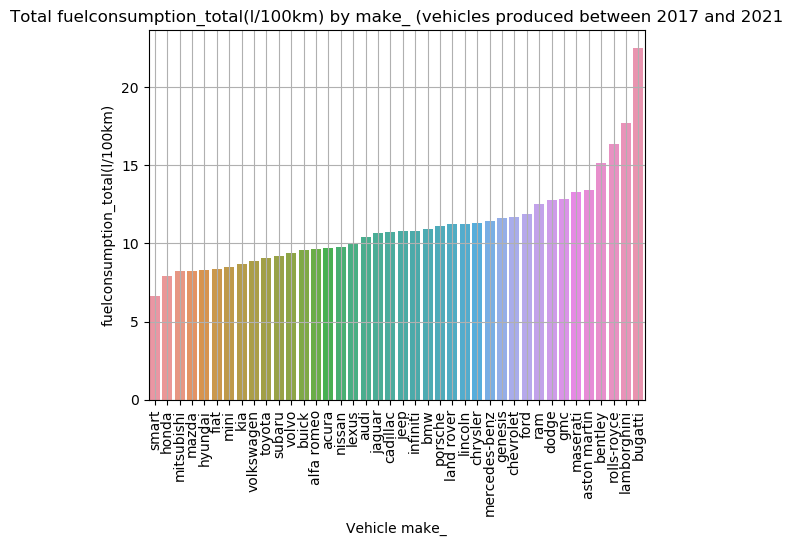

In [59]:
def generate_total_bar_chart_by_trait(df, trait, feature):
    sorted_fuel_cons = df.groupby(trait).mean()[feature].reset_index().sort_values(by=feature)
    sns.barplot(data=sorted_fuel_cons, x=trait, y=feature)
    plt.xticks(rotation=90)
    plt.title(f"Total {feature} by {trait} (vehicles produced between 2017 and 2021")
    plt.ylabel(f"{feature}")
    plt.xlabel(f"Vehicle {trait}")
    plt.grid(True)
    plt.show()
    
generate_total_bar_chart_by_trait(subset_copy, "make_", 'fuelconsumption_total(l/100km)')

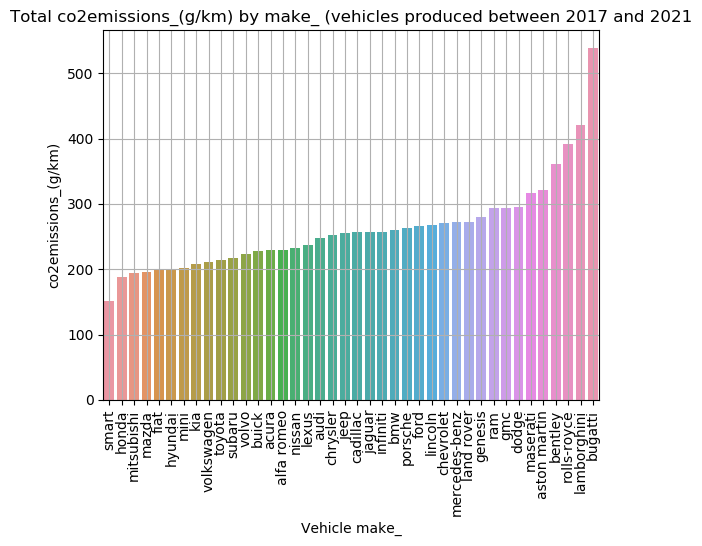

In [60]:
generate_total_bar_chart_by_trait(subset_copy, "make_", 'co2emissions_(g/km)')

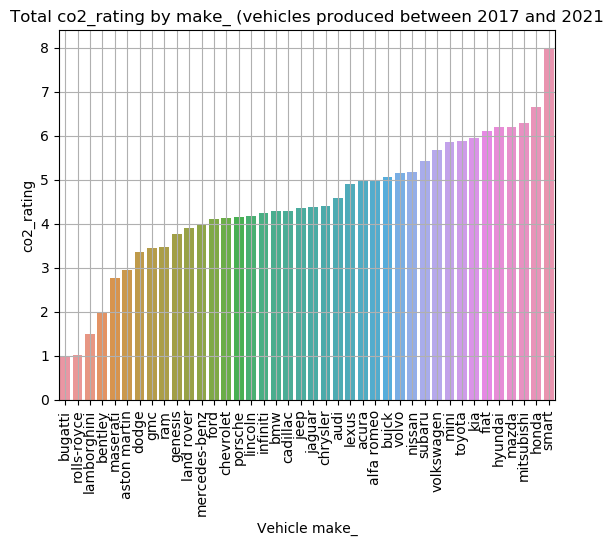

In [61]:
generate_total_bar_chart_by_trait(subset_copy, "make_", 'co2_rating')

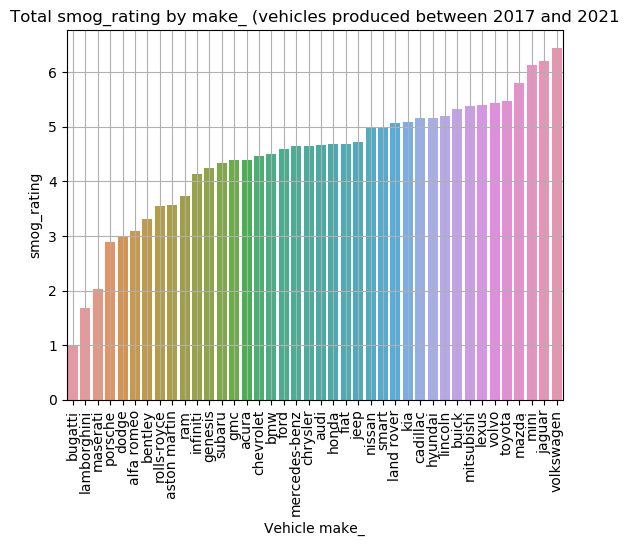

In [62]:
generate_total_bar_chart_by_trait(subset_copy, "make_", 'smog_rating')

### Inferential statistics: t-test, ANOVA, correlation, Chi-Square.